In [1]:

# Importing necessary modules
import torch
from torchvision.datasets import MNIST 
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np

In [2]:
# Function to transform and load the data with Torch
def get_dl(batchsize):

    # Define a transformation to convert the data into Tensors
    train_transforms = transforms.Compose([transforms.ToTensor()])
    
    # Download the train and test MNIST data and transform it into Tensors
    train_data = MNIST(root="./train.", train=True, download=True, transform=train_transforms)
    test_data = MNIST(root="./test.", train=True, download=True, transform=train_transforms)
    
    # Create DataLoader objects to efficiently load the training and test data in batches
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False, drop_last=True)
    
    # Return the DataLoader objects containing the train and test data
    return train_loader, test_loader

In [12]:

# Generator network class
class Generator(nn.Module):
    def __init__(self, batch_size, input_dim):
        super().__init__()
        self.batch_size = batch_size  # Batch size for input data
        self.input_dim = input_dim  # Dimension of the input data
        self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer 1
        self.LRelu = nn.LeakyReLU()  # Leaky ReLU activation function
        self.fc2 = nn.Linear(128, 1 * 28 * 28)  # Fully connected layer 2
        self.tanH = nn.Tanh()  # Hyperbolic Tangent activation function

    # Function for forward propagation
    def forward(self, x):
        layer1 = self.LRelu(self.fc1(x))  # Apply Leaky ReLU to the first fully connected layer
        layer2 = self.tanH(self.fc2(layer1))  # Apply Tanh to the second fully connected layer
        out = layer2.view(self.batch_size, 1, 28, 28)  # Reshape the output to match image dimensions
        return out


In [16]:
# Discriminator network class
class Discriminator(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size  # Batch size for input data
        self.fc1 = nn.Linear(1 * 28 * 28, 128)  # Fully connected layer 1
        self.LReLu = nn.LeakyReLU()  # Leaky ReLU activation function
        self.fc2 = nn.Linear(128, 1)  # Fully connected layer 2
        self.SigmoidL = nn.Sigmoid()  # Sigmoid activation function

    # Function for forward propagation
    def forward(self, x):
        flat = x.view(self.batch_size, -1)  # Flatten the input image
        layer1 = self.LReLu(self.fc1(flat))  # Apply Leaky ReLU to the first fully connected layer
        out = self.SigmoidL(self.fc2(layer1))  # Apply Sigmoid to the second fully connected layer
        return out.view(-1, 1).squeeze(1)  # Flatten the output and remove unnecessary d

In [17]:
import torch

# Function to train the GAN model
def train_model(no_of_epochs, disc, gen, optimD, optimG, dataloaders, loss_fn, input_size, batch_size):
    """
    Train a GAN model.

    Parameters:
    - no_of_epochs: Number of training epochs.
    - disc: Discriminator model.
    - gen: Generator model.
    - optimD: Optimizer for the Discriminator.
    - optimG: Optimizer for the Generator.
    - dataloaders: Dictionary containing data loaders for training and validation.
    - loss_fn: Loss function for training.
    - input_size: Dimension of the random noise input to the Generator.
    - batch_size: Batch size for training.

    Note: The 'dataloaders' dictionary should have keys 'train' and 'valid' for training and validation data.

    """
    
    # Set the device as CUDA or CPU based on availability
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    reall = 1  # Real label
    fakel = 0  # Fake label

    # Run training for each epoch
    for epoch in range(no_of_epochs):
        print('Epoch {}/{}'.format(epoch + 1, no_of_epochs))
        running_loss_D = 0
        running_loss_G = 0
        
        # Loop through the training phase
        for phase in ["train"]:
            # Iterate over batches in the data loader
            for inputs, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                
                # Convert labels into torch tensors with the proper size as per the batch size
                real_label = torch.full((batch_size,), reall, dtype=inputs.dtype, device=device)
                fake_label = torch.full((batch_size,), fakel, dtype=inputs.dtype, device=device)

                # Zero the gradients of the Discriminator optimizer
                optimD.zero_grad()
                
                # Compute output from the Discriminator
                output = disc(inputs)
                
                # Discriminator real loss
                D_real_loss = loss_fn(output, real_label)
                D_real_loss.backward()
                
                # Generate random noise data as input to the Generator
                noise = torch.randn(batch_size, input_size, device=device)
                
                # Generate fake images using the Generator
                fake = gen(noise)
                
                # Pass fake images through the Discriminator with gradient detachment
                output = disc(fake.detach())
                
                # Discriminator fake loss
                D_fake_loss = loss_fn(output, fake_label)
                D_fake_loss.backward()

                # Total loss for the Discriminator
                Disc_loss = D_real_loss + D_fake_loss
                running_loss_D = running_loss_D + Disc_loss
                
                # Update Discriminator's parameters
                optimD.step()

                # Zero the gradients of the Generator optimizer
                optimG.zero_grad()
                
                # Pass fake images obtained from the Generator to the Discriminator
                output = disc(fake)
                
                # Calculate Generator loss by giving fake images as input but providing real labels
                Gen_loss = loss_fn(output, real_label)
                running_loss_G = running_loss_G + Gen_loss
                
                # Backpropagation for the Generator
                Gen_loss.backward()
                
                # Update Generator's parameters
                optimG.step()
        
        # Print the losses for the current epoch
        print("Discriminator Loss : {}".format(running_loss_D))
        print("Generator Loss : {}".format(running_loss_G))


In [21]:
# Fixing the random seed for reproducibility
torch.manual_seed(4)

# Define batch size, number of training epochs, and input size for the latent variable
batch_size = 128
no_of_epochs = 10
input_size = 100

# Get training and test data loaders and put them inside a dictionary
train_loader, test_loader = get_dl(batch_size)
dl = {}
dl['train'] = train_loader
dl['valid'] = test_loader

# Create a Discriminator model
disc = Discriminator(batch_size)

# Create a Generator model
gen = Generator(batch_size, input_size)

# Optimizer for the Discriminator
optimD = torch.optim.Adam(disc.parameters(), lr=0.001, weight_decay=1e-05)

# Optimizer for the Generator
optimG = torch.optim.Adam(gen.parameters(), lr=0.001, weight_decay=1e-05)

# Binary Cross Entropy (BCE) loss function
loss_fn = torch.nn.BCELoss()

# Determine the device for training (GPU if available, otherwise CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
disc.to(device)
gen.to(device)

# Start training the GAN model
train_model(no_of_epochs, disc, gen, optimD, optimG, dl, loss_fn, input_size, batch_size)


Epoch 1/10
Discriminator Loss : 436.0501708984375
Generator Loss : 754.0474853515625
Epoch 2/10
Discriminator Loss : 581.1640014648438
Generator Loss : 557.9158935546875
Epoch 3/10
Discriminator Loss : 606.9691162109375
Generator Loss : 481.49859619140625
Epoch 4/10
Discriminator Loss : 648.0367431640625
Generator Loss : 401.1090393066406
Epoch 5/10
Discriminator Loss : 556.9235229492188
Generator Loss : 515.250244140625
Epoch 6/10
Discriminator Loss : 563.2786254882812
Generator Loss : 605.95556640625
Epoch 7/10
Discriminator Loss : 516.789306640625
Generator Loss : 553.6150512695312
Epoch 8/10
Discriminator Loss : 526.0089111328125
Generator Loss : 557.7036743164062
Epoch 9/10
Discriminator Loss : 508.441162109375
Generator Loss : 658.1758422851562
Epoch 10/10
Discriminator Loss : 506.7911071777344
Generator Loss : 652.499267578125


In [22]:
import matplotlib.pyplot as plt

# Function to plot an image
def show_image(img):
    # Convert the image from a tensor to a NumPy array
    npimg = img.numpy()
    # Transpose the NumPy array to the correct format for displaying
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


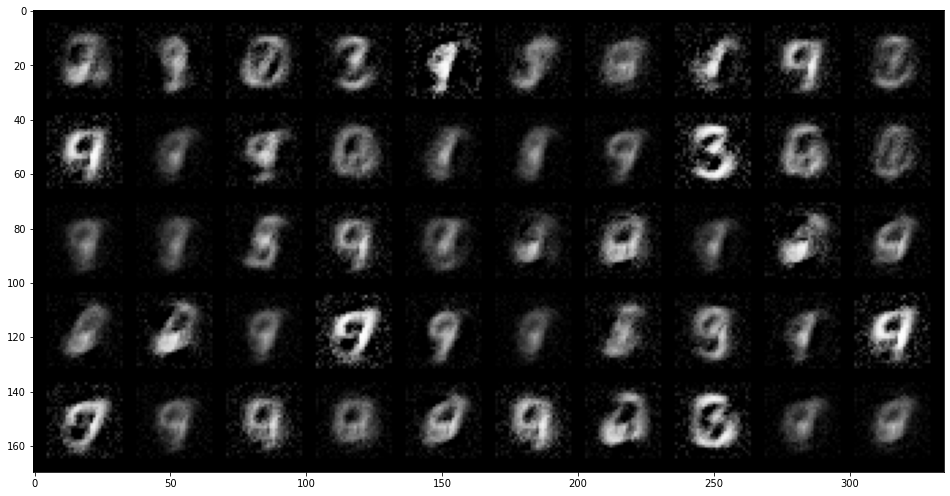

In [23]:

import torchvision

# Generate random noise for generating fake images
random_noise = torch.randn(128, input_size, device=device)

# Generate fake images from the random noise using the Generator
fake = gen(random_noise)
fake = fake.cpu()  # Move the generated fake images to the CPU for displaying

# Create a Matplotlib figure and axis for displaying the fake images
fig, ax = plt.subplots(figsize=(20, 8.5))

# Display the fake images in a grid (e.g., 10x5 grid)
show_image(torchvision.utils.make_grid(fake[0:50], 10, 5))

plt.show()